In [ ]:
!pip install control
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 37.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import control
import matplotlib.pyplot as plt
from scipy import signal
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control.matlab as control

num = [1]
den = [1, 1]
sys = control.TransferFunction(num, den)

delay = 0.5
n_pade = 2
num_delay, den_delay = control.pade(delay, n_pade)
sys_delay = control.TransferFunction(num_delay, den_delay)
sys_with_delay = sys * sys_delay

t = np.linspace(0, 15, 1000)

In [ ]:
def evaluate_system_performance(y, t):
    steady_state_value = y[-1]
    settling_time = None
    rise_time = None
    peak_value = max(y)
    overshoot_percentage = (peak_value - steady_state_value) / steady_state_value * 100 if steady_state_value != 0 else 0

    # محاسبه زمان نشست (2%)
    threshold = 0.02 * steady_state_value
    for i in range(len(y)):
        if abs(y[i] - steady_state_value) <= threshold:
            settling_time = t[i]
            break

    # محاسبه زمان صعود (10% تا 90%)
    norm_y = (y - y[0]) / (steady_state_value - y[0]) if steady_state_value != y[0] else y
    start_time, end_time = None, None
    for i, val in enumerate(norm_y):
        if start_time is None and val >= 0.1:
            start_time = t[i]
        if val >= 0.9:
            end_time = t[i]
            break
    if start_time is not None and end_time is not None:
        rise_time = end_time - start_time

    return {
        'Overshoot (%)': overshoot_percentage,
        'Settling Time (s)': settling_time,
        'Rise Time (s)': rise_time,
        'Peak': peak_value,
        'Steady State': steady_state_value
    }

def pid_tuning_ziegler_nichols(system):
    gain_margin, phase_margin, freq_gain, freq_phase = control.margin(system)
    ultimate_gain = gain_margin
    ultimate_period = 2 * np.pi / freq_gain

    proportional_gain = 0.6 * ultimate_gain
    integral_time = ultimate_period / 2
    derivative_time = ultimate_period / 8

    integral_gain = proportional_gain / integral_time
    derivative_gain = proportional_gain * derivative_time

    return proportional_gain, integral_gain, derivative_gain

def create_fuzzy_pid():
    # تعریف متغیرهای ورودی و خروجی
    error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'error')
    d_error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'delta_error')
    pid_output = ctrl.Consequent(np.linspace(-1, 1, 7), 'output')

    # تعریف توابع عضویت
    names = ['nb', 'nm', 'ns', 'z', 'ps', 'pm', 'pb']
    error.automf(names=names)
    d_error.automf(names=names)
    pid_output.automf(names=names)

    # تعریف قوانین
    rules = []
    for i in range(7):
        for j in range(7):
            rules.append(ctrl.Rule(
                error[names[i]] & d_error[names[j]],
                pid_output[names[min(6, max(0, i + j - 3))]]
            ))

    # ساخت سیستم کنترل فازی
    fuzzy_pid = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(fuzzy_pid)

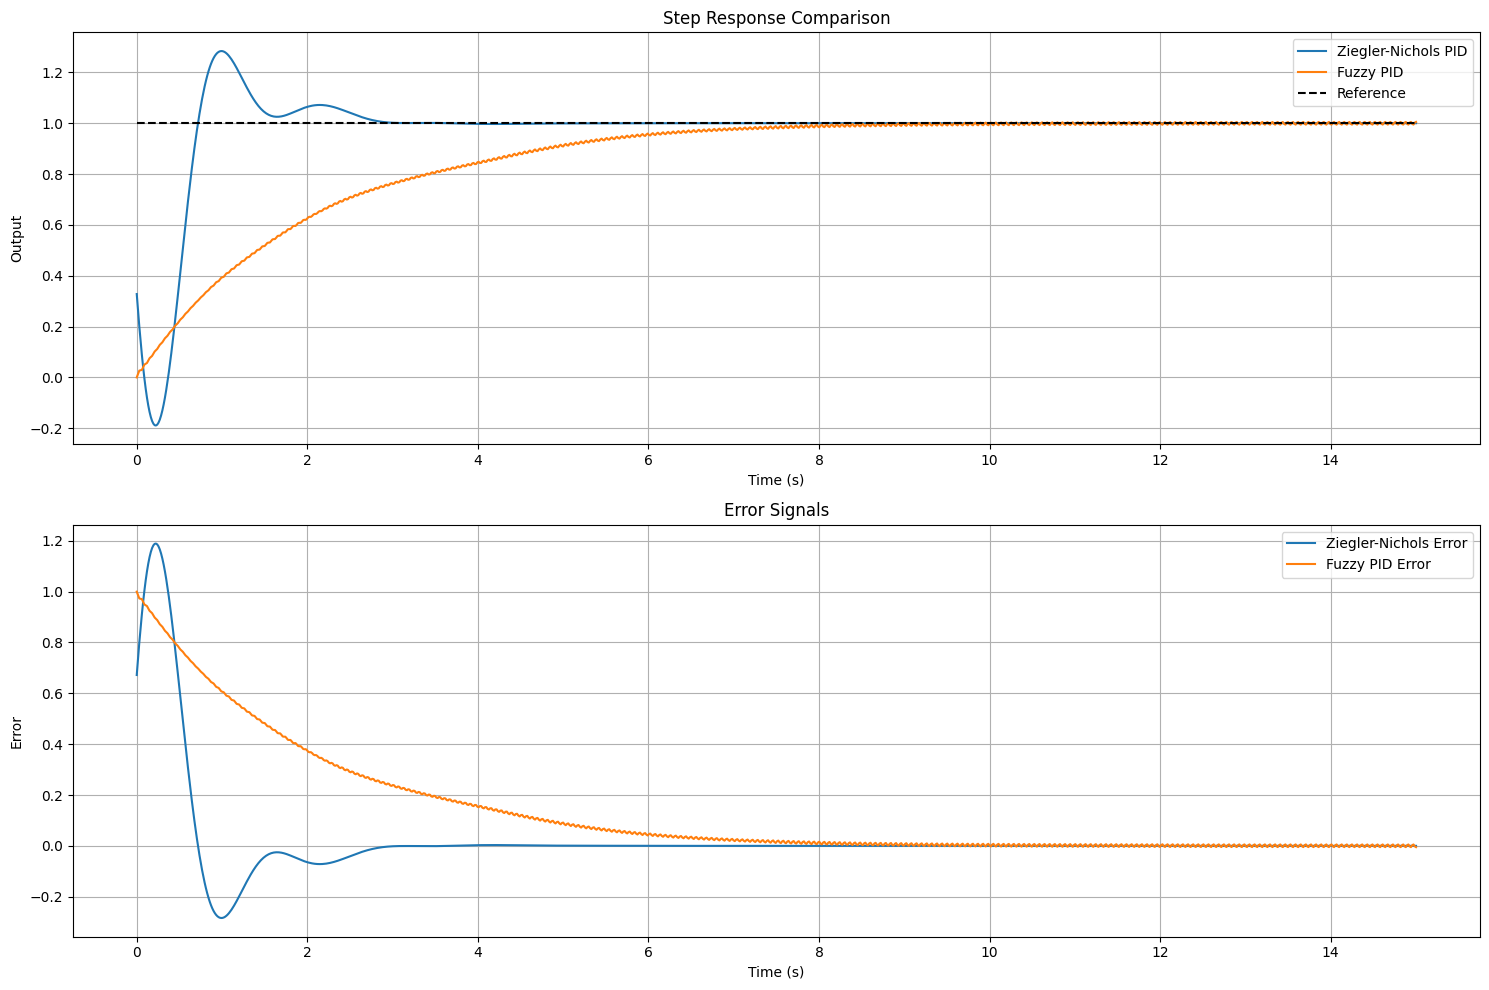

Ziegler-Nichols PID Performance:
Overshoot (%): 28.383
Settling Time (s): 0.721
Rise Time (s): 0.180
Peak: 1.284
Steady State: 1.000

Fuzzy PID Performance:
Overshoot (%): 0.000
Settling Time (s): 7.252
Rise Time (s): 4.580
Peak: 1.005
Steady State: 1.005


In [ ]:

# شبیه‌سازی PID Ziegler-Nichols
Kp_zn, Ki_zn, Kd_zn = pid_tuning_ziegler_nichols(sys_with_delay)
controller_zn = control.TransferFunction([Kd_zn, Kp_zn, Ki_zn], [1, 0])
closed_loop_zn = control.feedback(controller_zn * sys_with_delay, 1)
t_zn, y_zn = control.step_response(closed_loop_zn, T=t)

# شبیه‌سازی PID فازی
fuzzy_pid_simulation = create_fuzzy_pid()
y_simulated = np.zeros_like(t)
previous_error = 0
for step in range(len(t) - 1):
    current_error = 1 - y_simulated[step - 1] if step > 0 else 1
    delta_error = (current_error - previous_error) / (t[1] - t[0])

    fuzzy_pid_simulation.input['error'] = np.clip(current_error, -1, 1)
    fuzzy_pid_simulation.input['delta_error'] = np.clip(delta_error, -1, 1)
    fuzzy_pid_simulation.compute()

    dt = t[1] - t[0]
    y_simulated[step + 1] = y_simulated[step] + fuzzy_pid_simulation.output['output'] * dt
    previous_error = current_error

# محاسبه معیارهای عملکرد
zn_metrics = evaluate_system_performance(y_zn, t)
fuzzy_metrics = evaluate_system_performance(y_simulated, t)

# رسم نمودارها
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(t, y_zn, label='Ziegler-Nichols PID')
plt.plot(t, y_simulated, label='Fuzzy PID')
plt.plot(t, np.ones_like(t), 'k--', label='Reference')
plt.title('Step Response Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)

plt.subplot(212)
error_zn = 1 - y_zn
error_fuzzy = 1 - y_simulated
plt.plot(t, error_zn, label='Ziegler-Nichols Error')
plt.plot(t, error_fuzzy, label='Fuzzy PID Error')
plt.title('Error Signals')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# نمایش معیارهای عملکرد
print("Ziegler-Nichols PID Performance:")
for key, value in zn_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nFuzzy PID Performance:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: {value:.3f}")

In [ ]:
print("\nFuzzy PID Output (approximation at different time steps):")
for step in range(0, len(t), int(len(t)/5)):  # نمایش نتایج در زمان‌های مختلف
    print(f"Time: {t[step]:.2f}, Fuzzy PID Output: {fuzzy_pid_simulation.output['output']:.3f}")



# چاپ ضرایب PID Ziegler-Nichols
print("\nZiegler-Nichols PID Coefficients:")
print(f"Kp: {Kp_zn:.3f}")
print(f"Ki: {Ki_zn:.3f}")
print(f"Kd: {Kd_zn:.3f}")


Fuzzy PID Output (approximation at different time steps):
Time: 0.00, Fuzzy PID Output: 0.201
Time: 3.00, Fuzzy PID Output: 0.201
Time: 6.01, Fuzzy PID Output: 0.201
Time: 9.01, Fuzzy PID Output: 0.201
Time: 12.01, Fuzzy PID Output: 0.201

Ziegler-Nichols PID Coefficients:
Kp: 2.309
Ki: 2.732
Kd: 0.488
